# Time series classification without SARIMAX

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.tsa.seasonal import seasonal_decompose


In [18]:
df = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism_alemania.csv', sep=";", decimal=".", encoding="utf-8")
date_column = 'Fecha'
target_column = 'Alemania'

df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m')


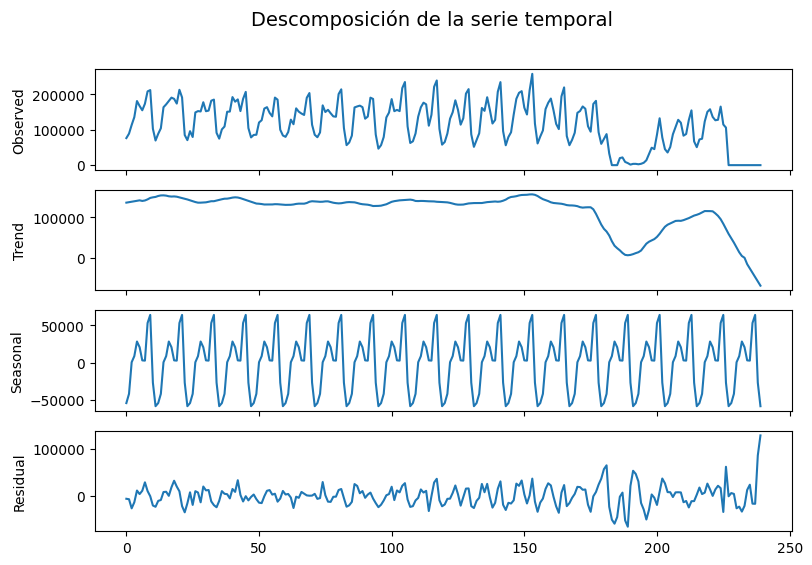

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_decompose = seasonal_decompose(df[target_column], model='additive', period=12, extrapolate_trend='freq')

res_decompose.observed.plot(ax=axs[0], legend=False)
axs[0].set_ylabel('Observed')
res_decompose.trend.plot(ax=axs[1], legend=False)
axs[1].set_ylabel('Trend')
res_decompose.seasonal.plot(ax=axs[2], legend=False)
axs[2].set_ylabel('Seasonal')
res_decompose.resid.plot(ax=axs[3], legend=False)
axs[3].set_ylabel('Residual')
fig.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.show()

## Global variables and feature lagging


In [20]:
cut_date = '2018-01'
df.drop(columns=['Mortalidad'], inplace=True)
# df_timed = df.set_index('Fecha')
df_train = df.loc[df["Fecha"] < cut_date].copy()
df_rest = df.loc[df["Fecha"] >= cut_date].copy()

seasonality = (12, 'ME') # See: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

### Data distribution

Normality test:
Statistics=0.967, p=0.000
Distribution test:


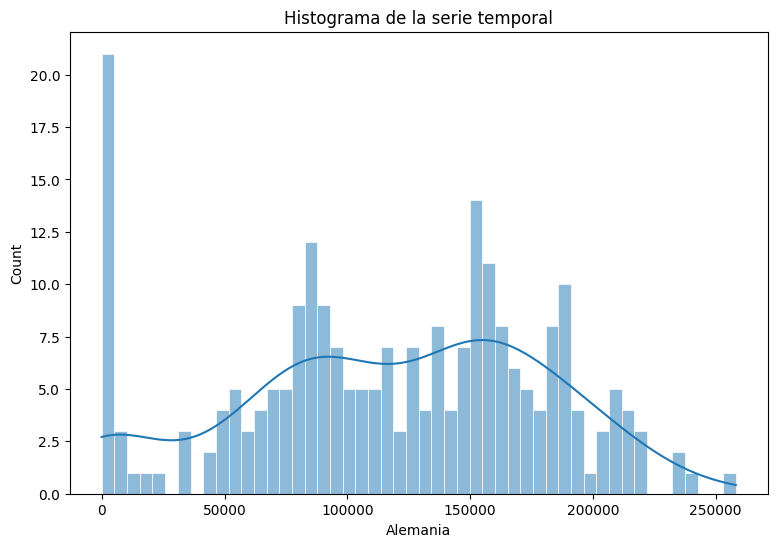

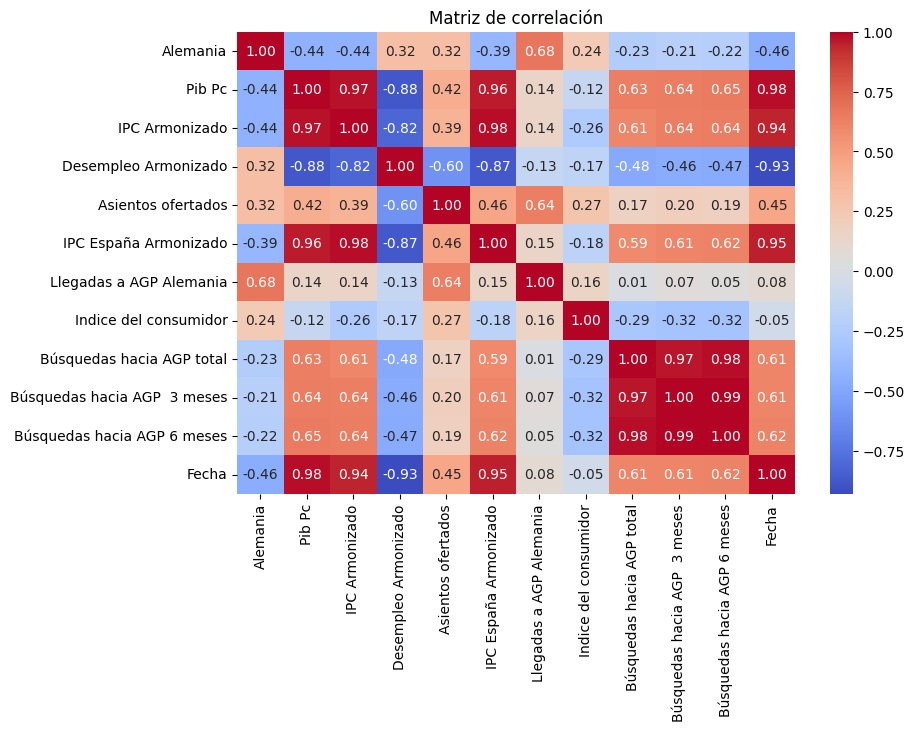

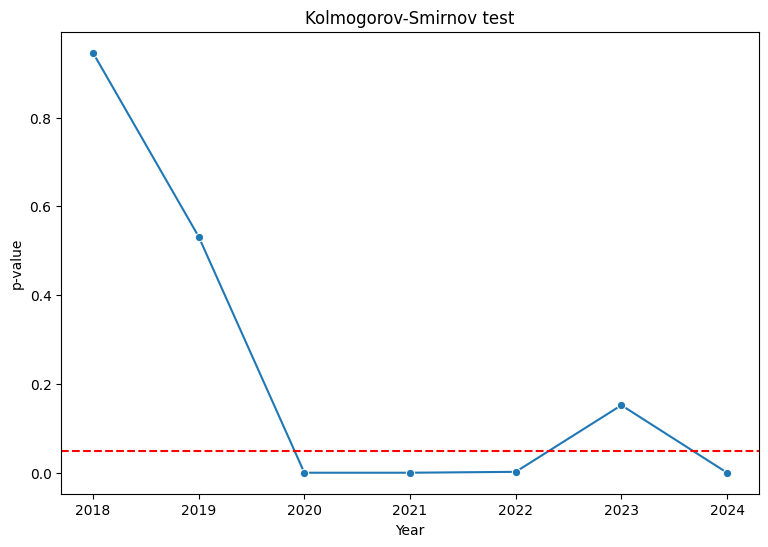

In [21]:
from scipy.stats import shapiro, ks_2samp
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(df[target_column], kde=True, bins=50, linewidth=0.5, edgecolor= 'white', ax = ax)
ax.set_title('Histograma de la serie temporal')
fig.show()

print('Normality test:')
stat, p = shapiro(df[target_column])
print('Statistics=%.3f, p=%.3f' % (stat, p))

fig, ax = plt.subplots(figsize=(9, 6))
corr_mat_df = df.corr()
sns.heatmap(corr_mat_df, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Matriz de correlación')
fig.show()

print('Distribution test:')
ks = {}
years_post = df_rest['Fecha'].dt.year.unique()
for year in years_post:
    data_prev =df_train['Alemania']
    data_post = df_rest.loc[df_rest['Fecha'].dt.year == year, target_column]
    stat, p = ks_2samp(data_prev, data_post)
    ks[year] = p

fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(
    x=list(ks.keys()),
    y=list(ks.values()),
    marker='o',
    ax=ax
)
ax.axhline(0.05, color='red', linestyle='--')
ax.set_title('Kolmogorov-Smirnov test')
ax.set_xlabel('Year')
ax.set_ylabel('p-value')
fig.show()



### lagging

In [22]:
from drift_prediction import time_series_transform_df

timeseries_train = time_series_transform_df(df_train, date_column, seasonality)
timeseries_rest = time_series_transform_df(df_rest, date_column, seasonality)
timeseries_df = time_series_transform_df(df, date_column, seasonality)

# Remove years 2020 and 2021 from rest and df
# timeseries_rest_trunc = timeseries_rest[timeseries_rest.index.year < 2020]
# timeseries_rest = pd.concat([timeseries_rest_trunc, timeseries_rest[timeseries_rest.index.year > 2021]])
# timeseries_df_trunc = timeseries_df[timeseries_df.index.year < 2020]
# timeseries_df = pd.concat([timeseries_df_trunc, timeseries_df[timeseries_df.index.year > 2021]])

new_target_column = target_column + '_t-0'

X_train = timeseries_train.drop(columns=[new_target_column])
y_train = timeseries_train[new_target_column]

## Feature selection
Options:
 - Permutation importance (model dependent)
 - mutual info (model independent)
 - correlation matrix (model independent)
 - Explicability (model dependent)

Finally opted for removing correlation redundant features and using mutual information to select the most important features.

Initial columns: 142
Removed columns: 77
Columns: {'Asientos ofertados_t-12', 'Alemania_t-7', 'IPC Armonizado_t-9', 'Desempleo Armonizado_t-1', 'Indice del consumidor_t-6', 'IPC España Armonizado_t-3', 'Indice del consumidor_t-2', 'IPC Armonizado_t-6', 'Pib Pc_t-1', 'IPC Armonizado_t-11', 'Desempleo Armonizado_t-10', 'IPC España Armonizado_t-4', 'Indice del consumidor_t-9', 'Pib Pc_t-2', 'IPC Armonizado_t-0', 'IPC Armonizado_t-2', 'IPC Armonizado_t-1', 'Asientos ofertados_t-6', 'Desempleo Armonizado_t-7', 'IPC España Armonizado_t-5', 'Indice del consumidor_t-5', 'Asientos ofertados_t-8', 'Pib Pc_t-6', 'IPC España Armonizado_t-2', 'Asientos ofertados_t-10', 'Desempleo Armonizado_t-11', 'Pib Pc_t-12', 'Pib Pc_t-0', 'IPC España Armonizado_t-7', 'Alemania_t-6', 'Indice del consumidor_t-10', 'IPC Armonizado_t-7', 'Pib Pc_t-5', 'Desempleo Armonizado_t-5', 'Desempleo Armonizado_t-3', 'IPC España Armonizado_t-6', 'Llegadas a AGP Alemania_t-8', 'IPC Armonizado_t-5', 'Asientos ofertados_t-3', 'D

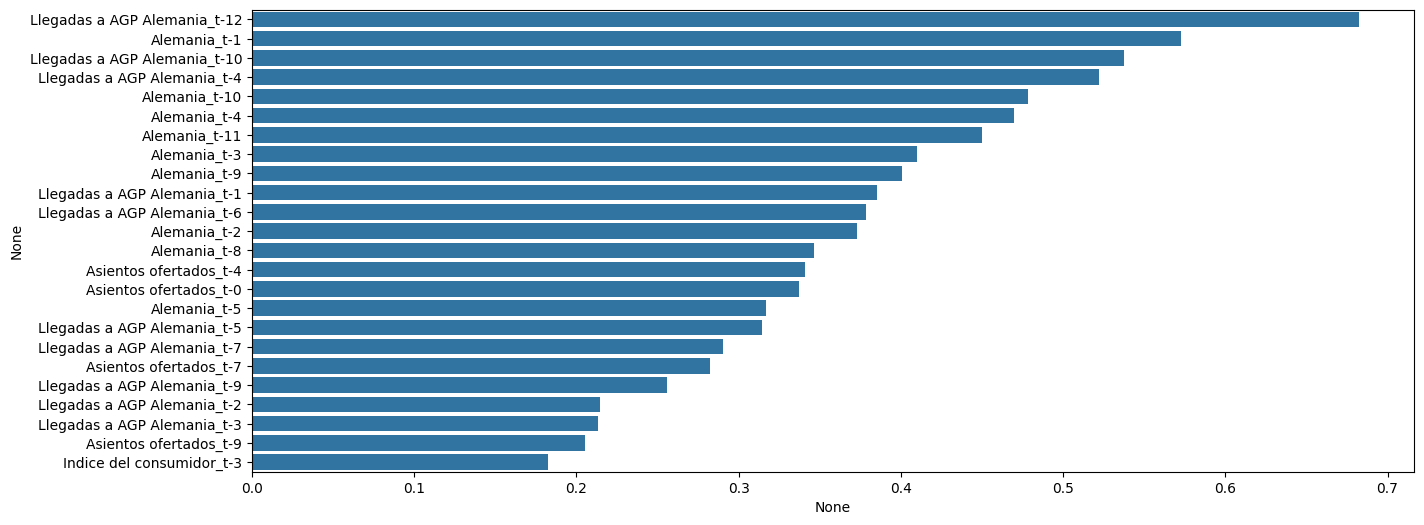

In [23]:
from sklearn.feature_selection import mutual_info_regression 

# Multicorrelation analysis and redundancy removal
corr_matrix = timeseries_train.corr('pearson')
max_corr_threshold = 0.8

corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > max_corr_threshold)]

to_drop = set()
for pair in high_corr_pairs.index:
    if pair[0] not in to_drop and pair[1] not in to_drop:
        pair_0_corr_target = corr_matrix[new_target_column].abs()[pair[0]]
        pair_1_corr_target = corr_matrix[new_target_column].abs()[pair[1]]
        if pair_0_corr_target >= pair_1_corr_target:
            to_drop.add(pair[1])
        else:
            to_drop.add(pair[0])
filtered_data = X_train.drop(columns=to_drop)
print(f"Initial columns: {X_train.shape[1]}")
print(f"Removed columns: {len(to_drop)}")
print(f"Columns: {to_drop}")
print(f"Final columns: {filtered_data.shape[1]}")

# Mutual information analysis for feature selection
min_mi_threshold = 0.1
mi = mutual_info_regression(filtered_data, y_train)
mi = pd.Series(mi, index=filtered_data.columns).abs().sort_values(ascending=False)
X_train_ft = X_train[mi.index[mi > min_mi_threshold]]

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.barplot(x=mi[mi > min_mi_threshold], y=mi[mi > min_mi_threshold].index, ax=ax)
fig.show()

print(X_train_ft.shape)

In [24]:
# from xgboost import XGBRegressor

# model = XGBRegressor(n_estimators=100)
# model.fit(filtered_data, y_train)
# ft_importance = model.feature_importances_
# ft_importance = pd.Series(ft_importance, index=filtered_data.columns).sort_values(ascending=False)

# sns.barplot(x=ft_importance[:20], y=ft_importance[:20].index)

# X_train_ft = X_train[ft_importance.index[:20]]


In [25]:
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor


# # model = RandomForestRegressor()
# model = XGBRegressor()
# model.fit(filtered_data, y_train)
# ft_importance = model.feature_importances_
# ft_importance = pd.Series(ft_importance, index=filtered_data.columns).sort_values(ascending=False)

# sns.barplot(x=ft_importance[:20], y=ft_importance[:20].index)
# X_train_ft = X_train[ft_importance.index[:20]]


In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, roc_auc_score, f1_score

timeseries_split = TimeSeriesSplit(n_splits=3, test_size=seasonality[0])

# model = RandomForestRegressor()
# GS = GridSearchCV(
#     model,
#     param_grid={
#         'n_estimators': [50, 100, 250, 500, 1000],
#         'max_depth': [1, 2, 5, 10, 20, 25],
#         'max_features': ['auto', 'sqrt', 'log2'],
#     },
#     cv=timeseries_split,
#     n_jobs=-1,
#     scoring=["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], # Scoring must be a str from one of the following: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     refit="r2",
# )

# model = GradientBoostingRegressor()
# GS = GridSearchCV(model, param_grid={'n_estimators': [50, 100, 250, 500, 1000], 'max_depth': [2, 5, 10, 20, 25, 50]}, cv=timeseries_split, n_jobs=-1)

# model = LinearRegression()
# GS = GridSearchCV(model, param_grid={}, cv=timeseries_split, n_jobs=-1)

# model = MLPRegressor()
# GS = GridSearchCV(model, param_grid={
#         'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)],
#         'alpha': [0.0001, 0.001, 0.01, 0.1],
#         'learning_rate': ['constant', 'invscaling', 'adaptive'],
#         'max_iter': [250, 500, 1000, 2500]
#     },
#     cv=timeseries_split,
#     n_jobs=-1,
#     scoring=["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], # Scoring must be a str from one of the following: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     refit="r2",
# )

# model = ElasticNet()
# GS = GridSearchCV(model, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_iter': [100, 1000, 10000, 100000, 1000000]}, cv=timeseries_split, n_jobs=-1)

# model = BayesianRidge()
# GS = GridSearchCV(model, param_grid={'n_iter': [100, 1000, 10000, 100000, 1000000]}, cv=timeseries_split, n_jobs=-1)

model = XGBRegressor()
GS = GridSearchCV(
    model,
    param_grid={
        'n_estimators': [50, 100, 250, 500, 1000],
        'max_depth': [2, 5, 10, 20, 25, 50],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'gamma': [0.0, 0.1, 0.2, 0.3],
        'random_state': [42]
    },
    cv=timeseries_split,
    n_jobs=-1,
    scoring=["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], # Scoring must be a str from one of the following: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    refit="neg_root_mean_squared_error"
)

GS.fit(X_train_ft, y_train)
params = GS.best_params_
print(GS.best_score_)
print(params)

-14849.204694442547
{'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 250, 'random_state': 42}


Year: 2019
	r2: -1.062590599632705
	mae: 47596.499348958336
	rmse: 58715.68984726674
Year: 2020
	r2: -27.91725620977416
	mae: 147546.884765625
	rmse: 153614.1050384154
Year: 2021
	r2: -5.618918442639532
	mae: 91172.55924479167
	rmse: 100192.89075160737
Year: 2022
	r2: -1.1844333215409644
	mae: 44285.115234375
	rmse: 51943.5328281435
Year: 2023
	r2: -0.6267772365912867
	mae: 48922.127604166664
	rmse: 56107.12850168624
Year: 2024
	r2: 0.0
	mae: 173147.2109375
	rmse: 177161.41082326212


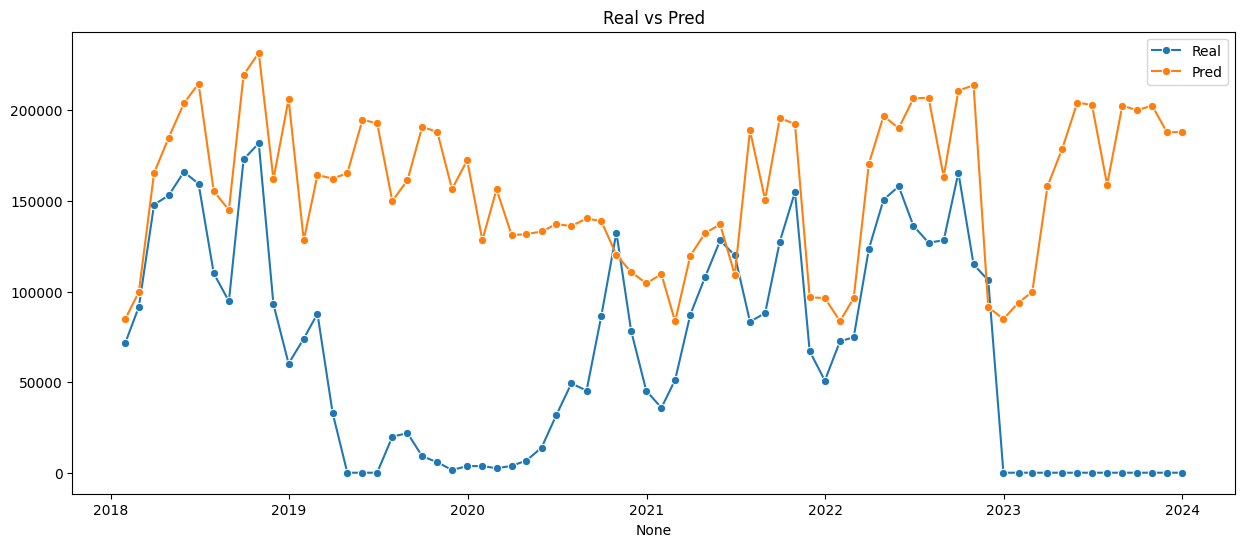

In [27]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

res = {
}
for year in timeseries_rest.index.year.unique():
    test = timeseries_rest.copy()[timeseries_rest.index.year == year]
    pred = GS.predict(test.drop(columns=[new_target_column])[X_train_ft.columns])
    print(f"Year: {year}")
    print('\tr2:', r2_score(test[new_target_column], pred))
    print('\tmae:', mean_absolute_error(test[new_target_column], pred))
    print('\trmse:', root_mean_squared_error(test[new_target_column], pred))
    res = {
        **res,
        year: {
            'real': test[new_target_column],
            'pred': pred,
        }
    }

res_df = pd.DataFrame(res).T

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
real = np.concatenate([vals for vals in res_df['real']])
pred = np.concatenate([vals for vals in res_df['pred']])

feats = pd.date_range(start='2018-01-01', periods=len(real), freq='ME')

sns.lineplot(x=feats, y=real, marker='o', ax=ax, label='Real')
sns.lineplot(x=feats, y=pred, marker='o', ax=ax, label='Pred')
ax.set_title('Real vs Pred')
fig.show()



In [28]:
for train_idx, test_idx in timeseries_split.split(X_train_ft):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    print("Train:", X_train_cv.index.min(), X_train_cv.index.max(), "- Test:", X_test_cv.index.min(), X_test_cv.index.max())
    

Train: 2006-01-31 00:00:00 2014-12-31 00:00:00 - Test: 2015-01-31 00:00:00 2015-12-31 00:00:00
Train: 2006-01-31 00:00:00 2015-12-31 00:00:00 - Test: 2016-01-31 00:00:00 2016-12-31 00:00:00
Train: 2006-01-31 00:00:00 2016-12-31 00:00:00 - Test: 2017-01-31 00:00:00 2017-12-31 00:00:00


## Prediction

Prediction pipeline

In [29]:
import shap.maskers
from sklearn.base import is_regressor, is_classifier

def time_series_predict(
    model: object,
    prev_shap_values: list,
    data: pd.DataFrame,
    target: pd.Series,
    explainer: shap.Explainer,
):
    def __euclidean_distance(X, Y):
        return np.sqrt(np.sum(np.square(X - Y)))

    def __manhattan_distance(X, Y):
        return np.sum(np.abs(X - Y))

    pred = model.predict(data)

    measure = {}
    if is_regressor(model):
        measure = {
            "R2": r2_score(target, pred),
            "MAE": mean_absolute_error(target, pred),
            "RMSE": root_mean_squared_error(target, pred),
        }
        print(measure)
    elif is_classifier(model):
        measure = {
            "ACC": accuracy_score(target, pred),
            "F1": f1_score(target, pred),
            "ROC_AUC": roc_auc_score(target, pred)
        }
        print(measure)
    else:
        raise ValueError("Model not supported")
    
    test_shap_values = explainer.shap_values(data)
    
    # prev_explain_means = np.mean(prev_shap_values, axis=0)
    # test_explain_means = np.mean(test_shap_values, axis=0)

    xai_feat_month = {}
    for i, col in enumerate(data.columns):
        xai_feat_month[col] = {}

        min_prev = min(val[i] for val in prev_shap_values)
        max_prev = max(val[i] for val in prev_shap_values)
        min_test = min(val[i] for val in test_shap_values)
        max_test = max(val[i] for val in test_shap_values)
        for j, val in enumerate(test_shap_values):
            prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
            test_val_norm = (val[i] - min_test) / (max_test - min_test)

            xai_feat_month[col][j+1] = {
                'prev': prev_val_norm,
                'test': test_val_norm
            }
    
    # max_feats = 20

    # test_data = pd.DataFrame({
    #     'feature': data.columns.tolist(),
    #     'shap_value': test_explain_means,
    #     'type': 'Test'
    # })
    # test_data_max = test_data.reindex(test_data['shap_value'].abs().sort_values(ascending=False).index).head(max_feats)

    # prev_data = pd.DataFrame({
    #     'feature': data.columns.tolist(),
    #     'shap_value': prev_explain_means,
    #     'type': 'Previous'
    # })
    # prev_data_max = prev_data[prev_data['feature'].isin(test_data_max['feature'])]

    # explained_max = pd.concat([prev_data_max, test_data_max])   

    # # Create the bar chart using Seaborn's hue argument
    # fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed
    # sns.barplot(x='shap_value', y='feature', hue='type', data=explained_max, ax=ax, linewidth=0)

    # # Customize the plot for clarity
    # ax.set_title('Explained Importance by Feature Type (Year: {})'.format(data.index.year.unique()[0]))
    # ax.set_xlabel('SHAP Value')
    # ax.set_ylabel('Feature')
    # ax.legend(title='Data Type')  # Add a legend for clarity

    # fig.tight_layout()  # Adjust spacing to prevent overlapping elements
    # fig.show()

    # # Normalize shap values
    # prev_explain_means = (prev_explain_means - np.mean(prev_explain_means)) / np.std(
    #     prev_explain_means
    # )
    # test_explain_means = (test_explain_means - np.mean(test_explain_means)) / np.std(
    #     test_explain_means
    # )

    # xai_results = pd.DataFrame(
    #     {
    #         "Previous explained importance": prev_explain_means,
    #         "Test explained importance": test_explain_means,
    #     },
    #     index=data.columns,
    # )
    return pred, measure, xai_feat_month

def prediction(
        ai,
        train_data,
        train_target,
        test_val_data,
        total_data,
        target_col,
):
    ai.fit(train_data, train_target)
    # explainer = shap.KernelExplainer(ai.predict, train_data)
    # explainer = shap.Explainer(ai, masker=shap.maskers.Independent(data=train_data))
    explainer = shap.TreeExplainer(ai, train_data)
    train_shap = explainer.shap_values(train_data.head(24))

    preds = {}
    xais = {}
    measures = {
        'train': {
            'R2': r2_score(train_target, ai.predict(train_data)),
            'MAE': mean_absolute_error(train_target, ai.predict(train_data)),
            'RMSE': root_mean_squared_error(train_target, ai.predict(train_data))
        }
    }

    for year in test_val_data.index.year.unique():
        print(year)
        test_year = test_val_data[test_val_data.index.year == year]

        X_test = test_year.drop(columns=[target_col])
        y_test = test_year[target_col]

        preds[year], measures[str(year)], xais[year] = time_series_predict(
            model=ai,
            prev_shap_values=train_shap,
            data=X_test,
            target=y_test,
            explainer=explainer
        )
        print("-----")

    # xais dataframe creation
    index = []
    rows = []
    for year, xai_feat in xais.items():
        for feat, month in xai_feat.items():
            for month, val in month.items():
                index.append(pd.to_datetime(f"{year}-{month}", format='%Y-%m'))
                rows.append(
                    [feat,
                    val['prev'],
                    val['test']]
                )

    xai_df = pd.DataFrame(rows, index=index, columns=['Feature', 'Previous', 'Test'])


    fig = plt.figure(figsize=(25, 10))
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    sns.lineplot(x=total_data.index, y=total_data[target_col], label='Real', linewidth=3, alpha=0.5, color='gray', ax=ax1)
    for year in preds.keys():
        sns.lineplot(x=total_data[total_data.index.year == year].index, y=preds[year], label=f'Predicción {year}', marker='o', markeredgewidth=0, markersize=4, ax=ax1)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.125, 1))
    ax1.set_title('Predicción de la serie temporal', fontsize=14)

    ax2_1 = plt.subplot2grid((3, 3), (1, 0))
    ax2_2 = plt.subplot2grid((3, 3), (1, 1))
    ax2_3 = plt.subplot2grid((3, 3), (1, 2))
    
    measures_df = pd.DataFrame(measures).T

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_1 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[0]]):
        ax2_1.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_1.set_title(measures_df.columns[0])

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_2 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[1]]):
        ax2_2.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_2.set_title(measures_df.columns[1])

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_3 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[2]]):
        ax2_3.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_3.set_title(measures_df.columns[2])

    fig.tight_layout(pad=1.0)
    fig.show()

    
    # fig, ax = plt.subplots(2, 1, figsize=(25, 15))
    
    # sns.lineplot(x=xai_df.index, y=xai_df['Previous'], hue=xai_df['Feature'], ax=ax[0])
    # sns.lineplot(x=xai_df.index, y=xai_df['Test'], hue=xai_df['Feature'], ax=ax[1])
    
    # ax[0].set_title('Importancia de las variables explicativas PREV')
    # ax[1].set_title('Importancia de las variables explicativas TEST')
    # ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=7)
    # ax[0].legend([])
   
    # fig.show()


    return model, explainer, preds, measures, xai_df


metrics drift pipeline

In [30]:
def calculate_z_score(val, batch):
        if batch == [] or np.std(batch) == 0:
            return 0
        return (val - np.median(batch)) / np.std(batch)

def calculate_measures_drift(
    measures: dict,
    train_measure: dict,
    drift_threshold: float
):
    drift = {}
    measures_variance = {}

    batch = {
        'R2': [],
        'MAE': [],
        'RMSE': []
    }
    for key, measure in measures.items():
        r2_variance = ((measure['R2'] - train_measure['R2'])/train_measure['R2']) * 100 if measure['R2'] != np.nan else 0
        mae_variance = ((measure['MAE'] - train_measure['MAE'])/train_measure['MAE']) * 100
        rmse_variance = ((measure['RMSE'] - train_measure['RMSE'])/train_measure['RMSE']) * 100

        measures_variance[key] = {
            'R2': r2_variance,
            'MAE': mae_variance,
            'RMSE': rmse_variance
        }

        r2_z_score = calculate_z_score(r2_variance, batch['R2'])
        mae_z_score = calculate_z_score(mae_variance, batch['MAE'])
        rmse_z_score = calculate_z_score(rmse_variance, batch['RMSE'])

        concept_drift_score = np.sqrt(r2_z_score**2 + mae_z_score**2 + rmse_z_score**2)
        drift[key] = concept_drift_score

        # Usamos el drift threshold para detectar el cambio de concepto y si no se produce añadimos los valores a la lista de varianzas
        if concept_drift_score > drift_threshold:
            print(f"Concept drift detected at year {key}")
        else:
            batch['R2'].append(r2_variance)
            batch['MAE'].append(mae_variance)
            batch['RMSE'].append(rmse_variance)

    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.lineplot(drift.values(), marker='o', markeredgewidth=0, markersize=4, ax=ax)
    ax.set_xticks(ticks=range(len(drift)), labels=drift.keys())
    ax.hlines(drift_threshold, 0, len(drift), colors='r', linestyles='dashed')
    ax.set_title('Metrics drift detection')
    ax.legend([])
    fig.show

    return drift, measures_variance

### Prediction with complete data

2019
{'R2': 0.3082535610987128, 'MAE': 29175.104166666668, 'RMSE': 34003.3038858379}
-----
2020
{'R2': -20.759091698150844, 'MAE': 118348.95963541667, 'RMSE': 133251.75411135468}
-----
2021
{'R2': -1.4192505044655124, 'MAE': 53218.983723958336, 'RMSE': 60573.659539763146}


/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_pre

-----
2022
{'R2': 0.2882648518799503, 'MAE': 25602.705729166668, 'RMSE': 29649.76764383105}
-----
2023
{'R2': 0.01990293498499973, 'MAE': 34186.291666666664, 'RMSE': 43550.03852779105}
-----
2024
{'R2': 0.0, 'MAE': 155229.07161458334, 'RMSE': 160355.98957499478}


/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_pre

-----


Feature  Previous      Test
2019-01-01                    Alemania_t-12  0.153807  0.311539
2019-02-01                    Alemania_t-12  0.284351  0.396416
2019-03-01                    Alemania_t-12  0.598794  0.855239
2019-04-01                    Alemania_t-12  0.846599  0.855278
2019-05-01                    Alemania_t-12  0.897020  0.955513
...                                     ...       ...       ...
2024-08-01  Búsquedas hacia AGP 6 meses_t-0       NaN       NaN
2024-09-01  Búsquedas hacia AGP 6 meses_t-0       NaN       NaN
2024-10-01  Búsquedas hacia AGP 6 meses_t-0       NaN       NaN
2024-11-01  Búsquedas hacia AGP 6 meses_t-0       NaN       NaN
2024-12-01  Búsquedas hacia AGP 6 meses_t-0       NaN       NaN

[10224 rows x 3 columns]

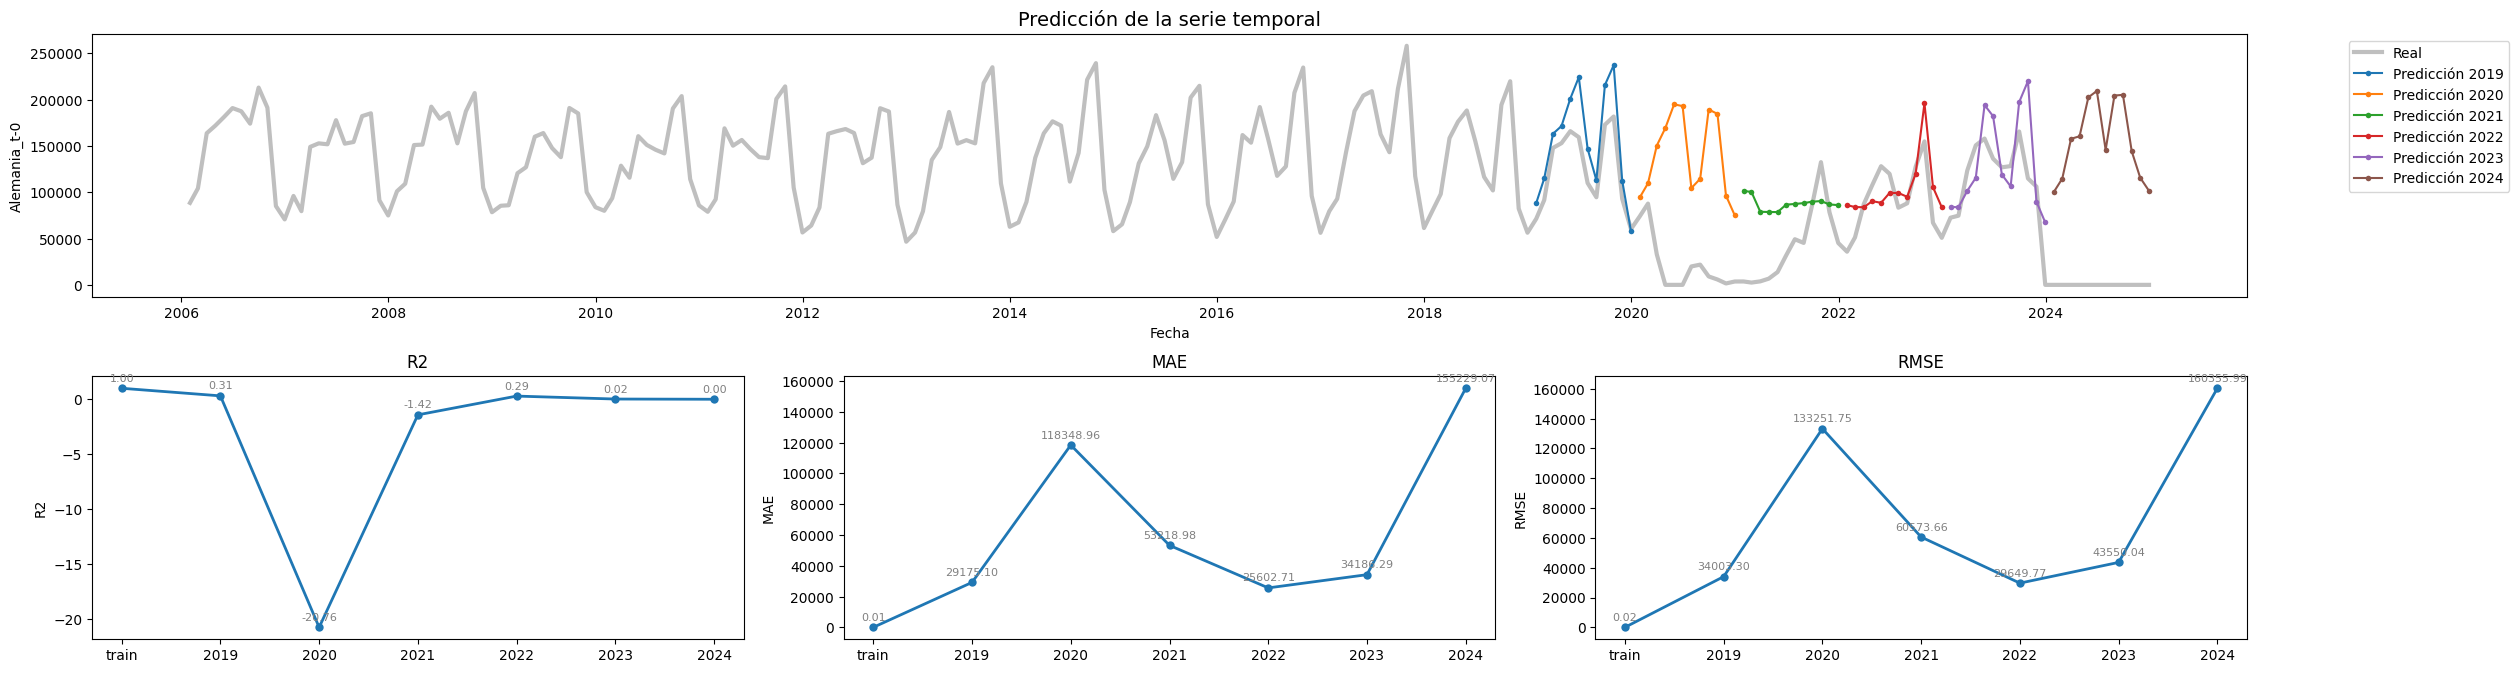

In [31]:
model = XGBRegressor(**params)
model, exp, preds, measures, xais = prediction(
    ai=model,
    train_data=X_train,
    train_target=y_train,
    test_val_data=timeseries_rest,
    total_data=timeseries_df,
    target_col=new_target_column
)
xais

{'2019': 0.0, '2020': 0.0, '2021': 1.0616053182364216, '2022': 1.054888366566175, '2023': 0.2189771606014725, '2024': 4.665434860677284}


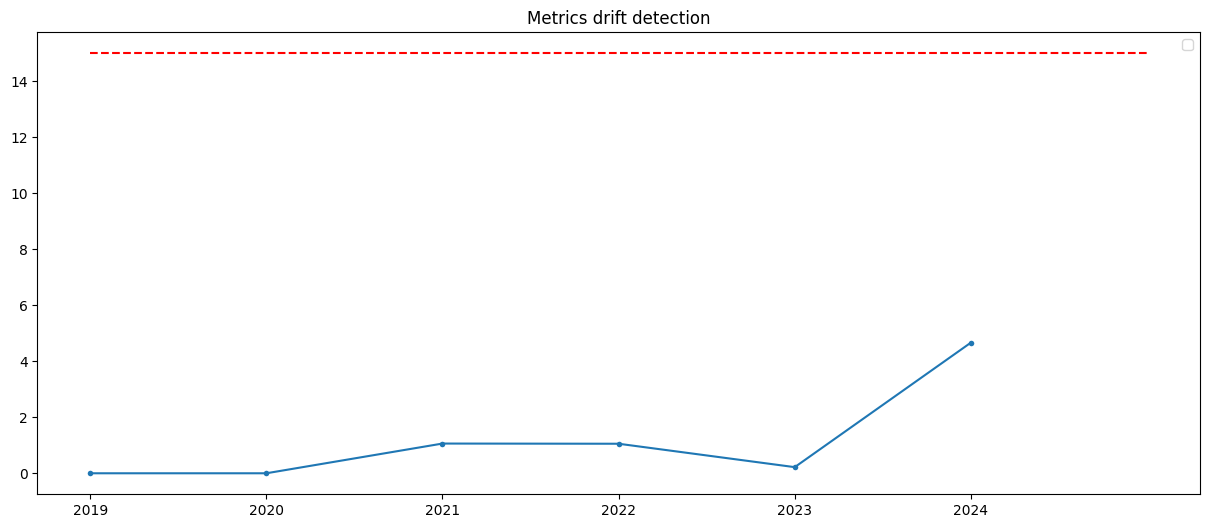

In [32]:
threshold = 15

new_measures = measures.copy()
new_measures.pop(list(measures.keys())[0])
drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)
print(drift)

### Predictions with feature importance data

Prediction with the most important features selected by mutual information and removed the redundant features by correlation matrix.

2019
{'R2': -0.9454052488602314, 'MAE': 45575.315755208336, 'RMSE': 57023.345372270254}
-----
2020
{'R2': -27.486670213819423, 'MAE': 146410.32486979166, 'RMSE': 152466.13722455362}
-----
2021
{'R2': -6.15845951788983, 'MAE': 93154.32486979167, 'RMSE': 104196.51143188312}
-----
2022
{'R2': -1.0641599023677384, 'MAE': 41874.897786458336, 'RMSE': 50493.30014093064}
-----
2023
{'R2': -0.5690307926186557, 'MAE': 47935.55859375, 'RMSE': 55102.30072422351}
-----
2024
{'R2': 0.0, 'MAE': 172525.78515625, 'RMSE': 176824.48514169332}
-----


Feature  Previous      Test
2019-01-01  Llegadas a AGP Alemania_t-12  0.032775  0.000000
2019-02-01  Llegadas a AGP Alemania_t-12  0.208092  0.055350
2019-03-01  Llegadas a AGP Alemania_t-12  0.725372  0.714569
2019-04-01  Llegadas a AGP Alemania_t-12  0.782082  0.757926
2019-05-01  Llegadas a AGP Alemania_t-12  0.833038  0.824802
...                                  ...       ...       ...
2024-08-01   Llegadas a AGP Alemania_t-9  0.098464  0.000000
2024-09-01   Llegadas a AGP Alemania_t-9  0.416478  0.022742
2024-10-01   Llegadas a AGP Alemania_t-9  0.308198  0.034825
2024-11-01   Llegadas a AGP Alemania_t-9  0.268264  0.013117
2024-12-01   Llegadas a AGP Alemania_t-9  0.260133  0.012363

[1440 rows x 3 columns]

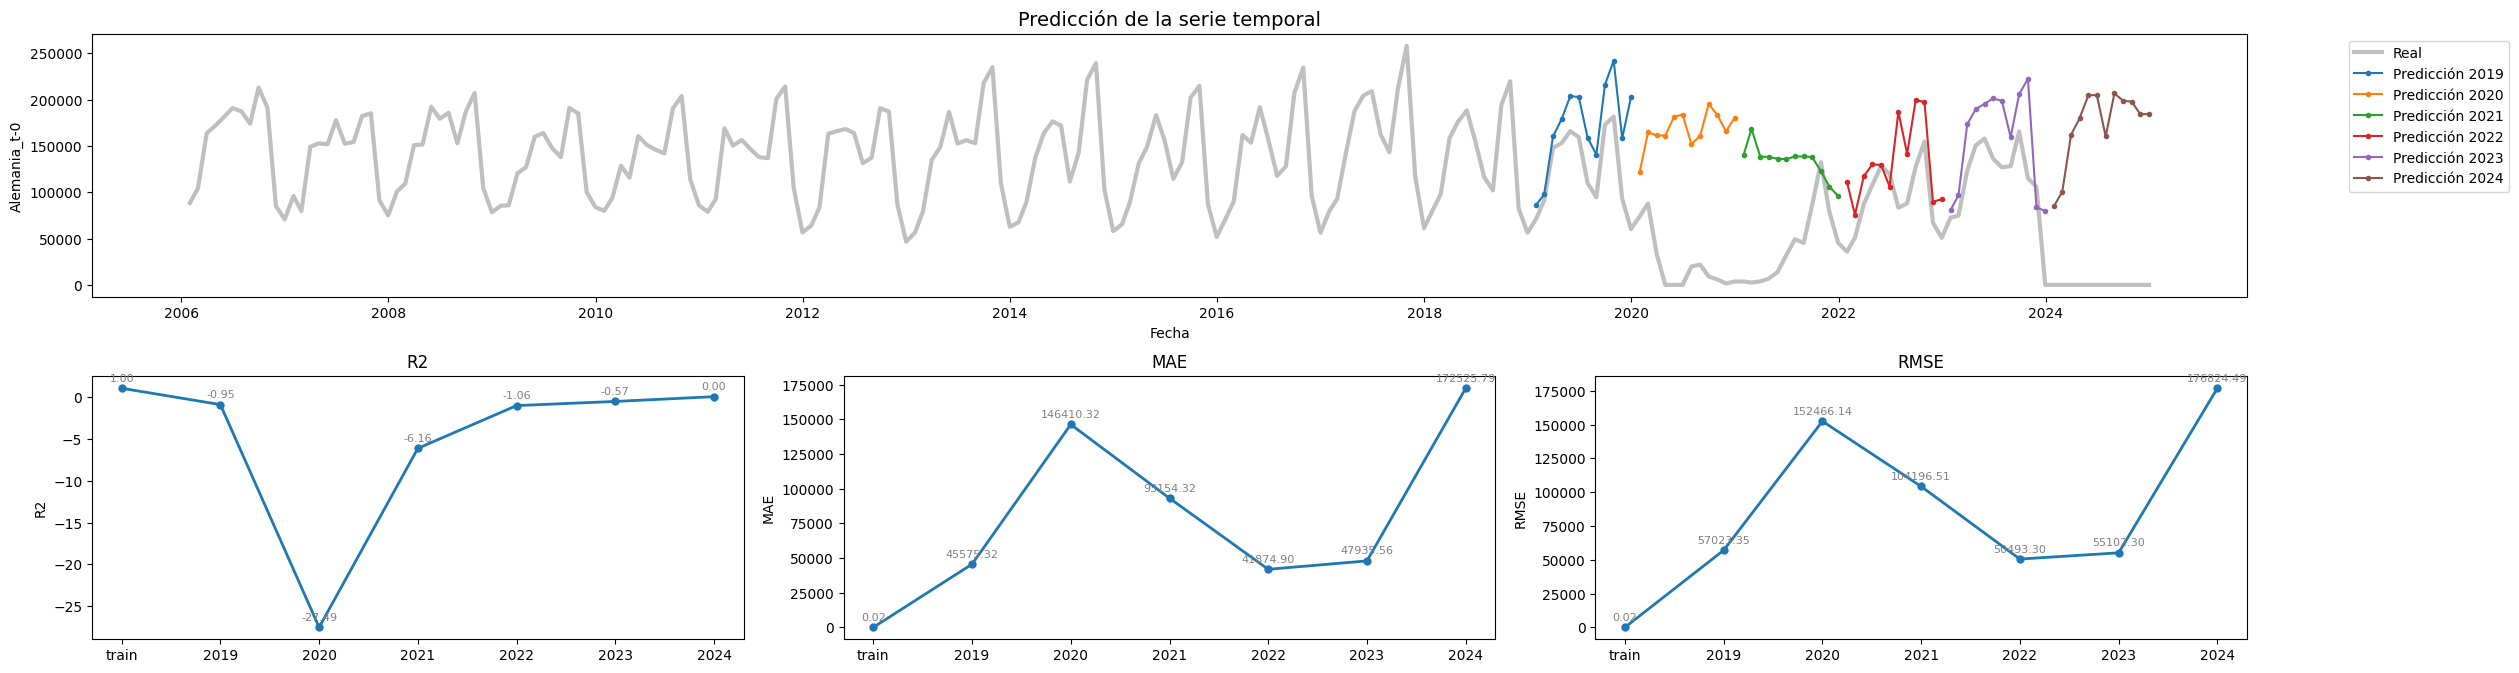

In [33]:
k=20
idx = mi.index[:k].to_list()
# idx = ft_importance.index[:k].to_list()
train_corr = timeseries_train.copy()[idx]
idx.append(new_target_column)
test_val_corr = timeseries_rest.copy()[idx]
total_corr = timeseries_df.copy()[idx]
model = XGBRegressor(**params)

model, exp, preds, measures, xais = prediction(
    ai=model,
    train_data=train_corr,
    train_target=y_train,
    test_val_data=test_val_corr,
    total_data=total_corr,
    target_col=new_target_column
)
xais

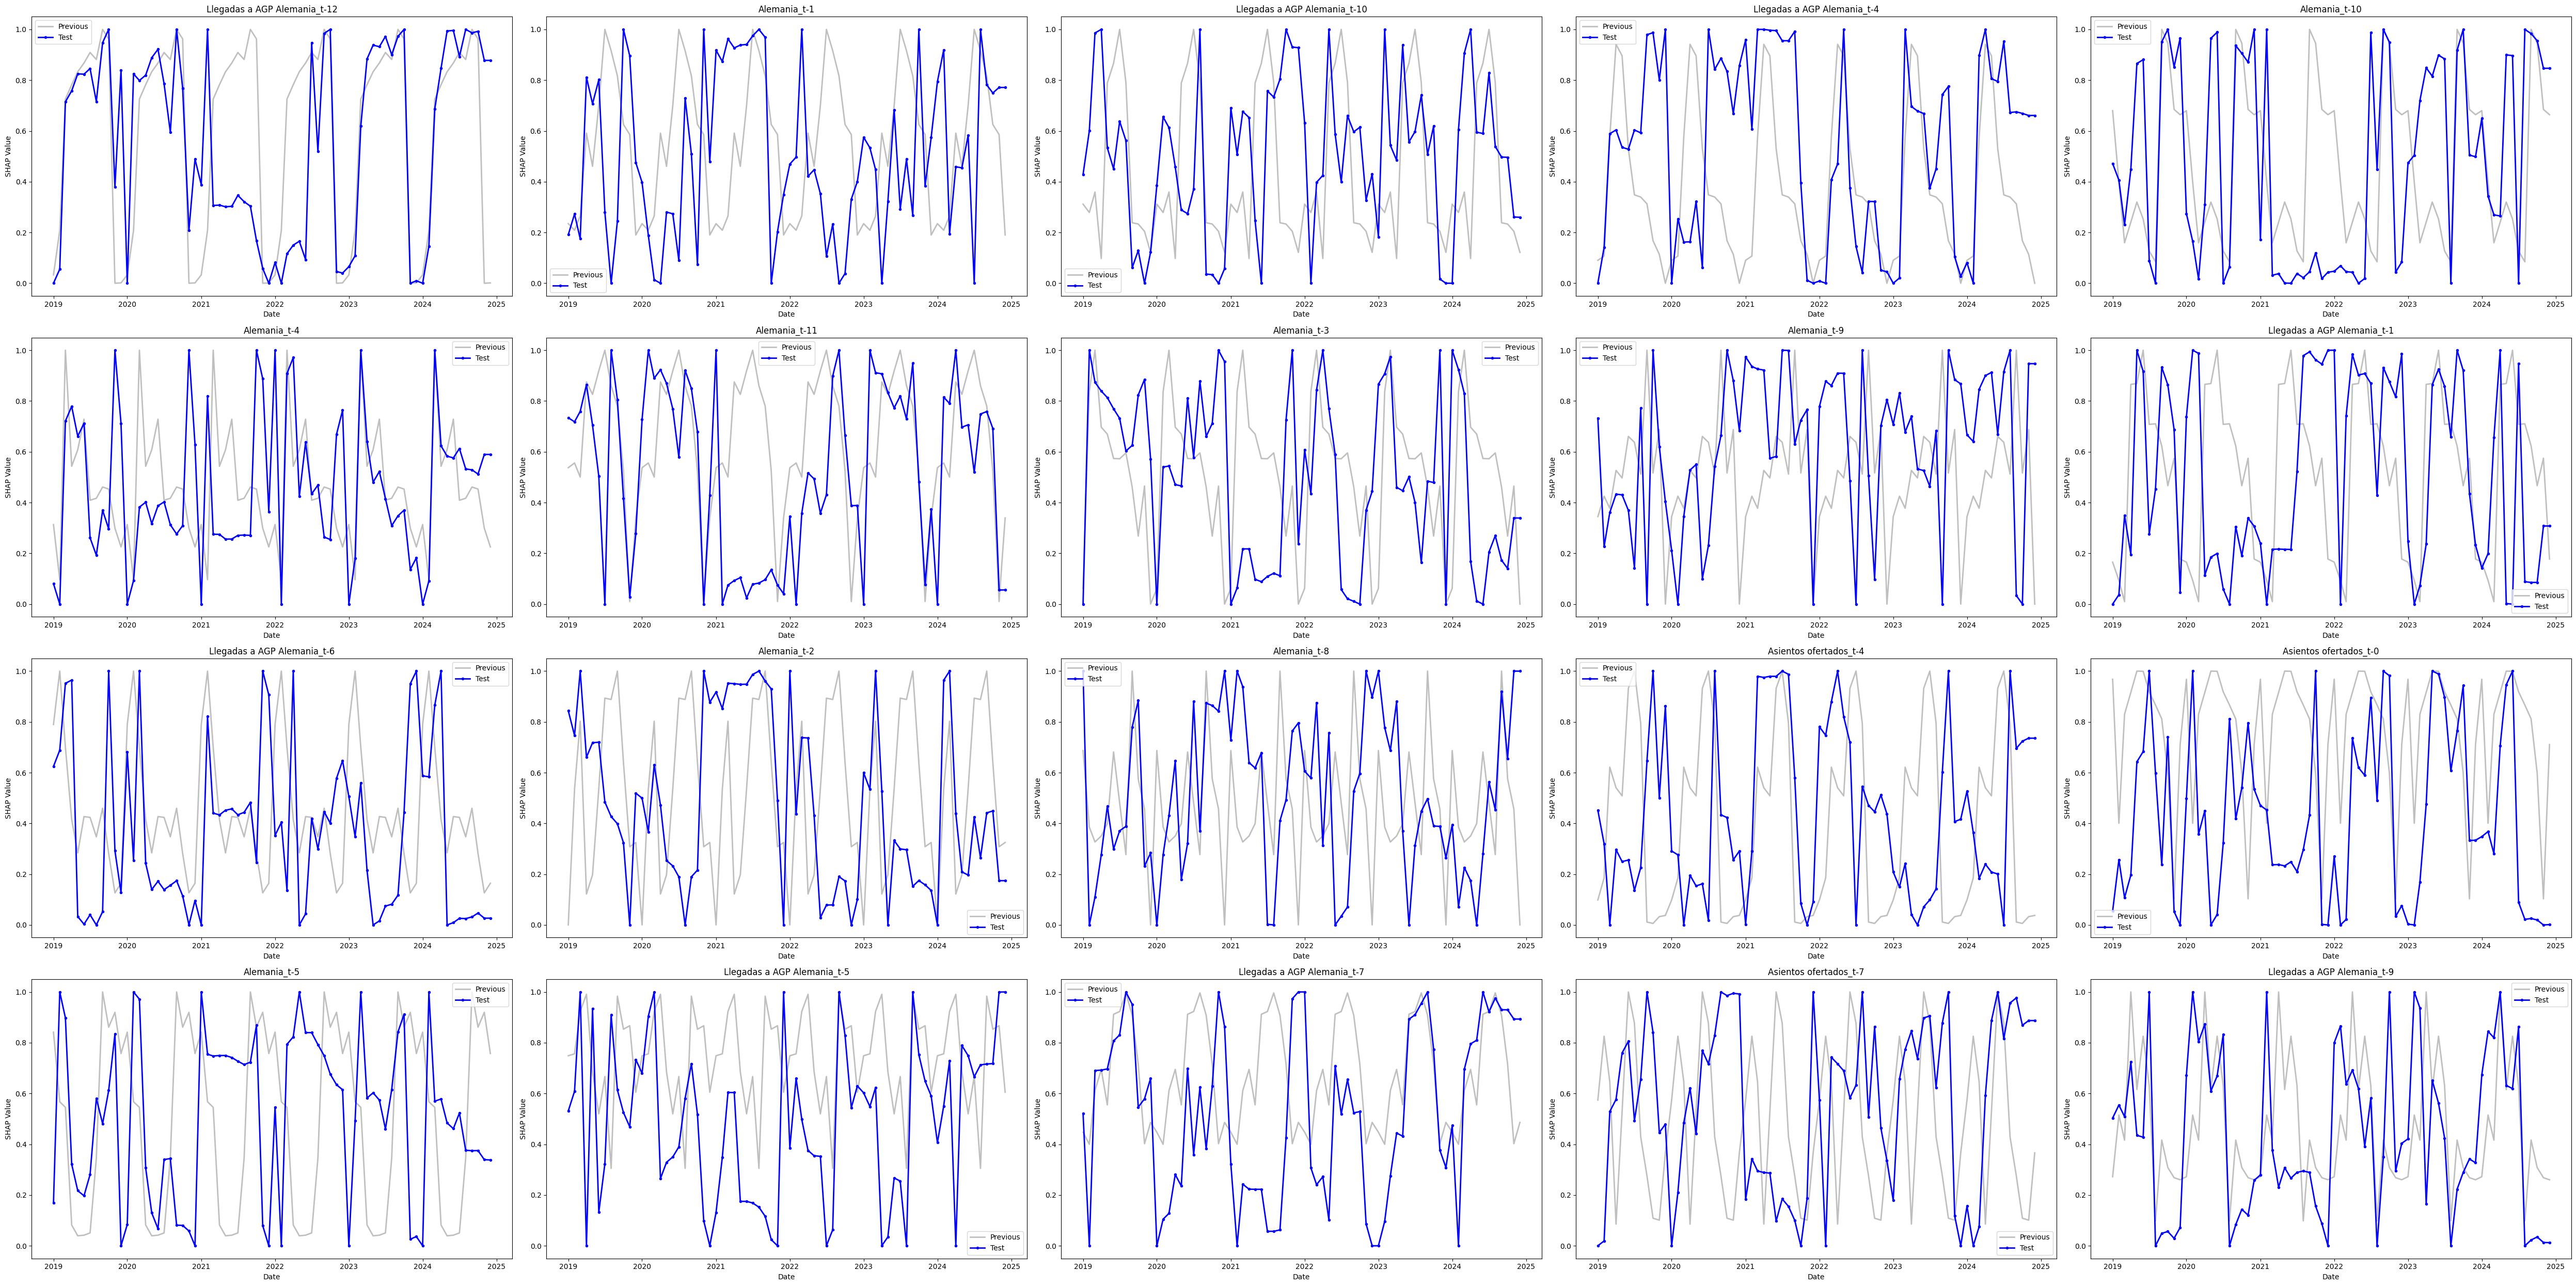

In [34]:
feats = xais['Feature'].unique()
x = round(len(feats)**0.5, 0)+1
fig, ax = plt.subplots(int(x)-1, int(x), figsize=(50, 25))
for i in range(len(feats)):
    xais_feat = xais[xais['Feature'] == feats[i]]
    xais_feat = xais_feat.drop(columns=['Feature'])
    sns.lineplot(x=xais_feat.index, y=xais_feat['Previous'], ax=ax[int(i/x), int(i%x)], label='Previous', linewidth=2, alpha=0.5, color='gray')
    sns.lineplot(x=xais_feat.index, y=xais_feat['Test'], ax=ax[int(i/x), int(i%x)], label='Test', linewidth=2, alpha=1, color='b', marker='o', markeredgewidth=0, markersize=4)
    ax[int(i/x), int(i%x)].set_xlabel('Date')
    ax[int(i/x), int(i%x)].set_ylabel('SHAP Value')
    ax[int(i/x), int(i%x)].set_title(feats[i])

fig.tight_layout()
fig.show()


Concept drift detected at year 2020


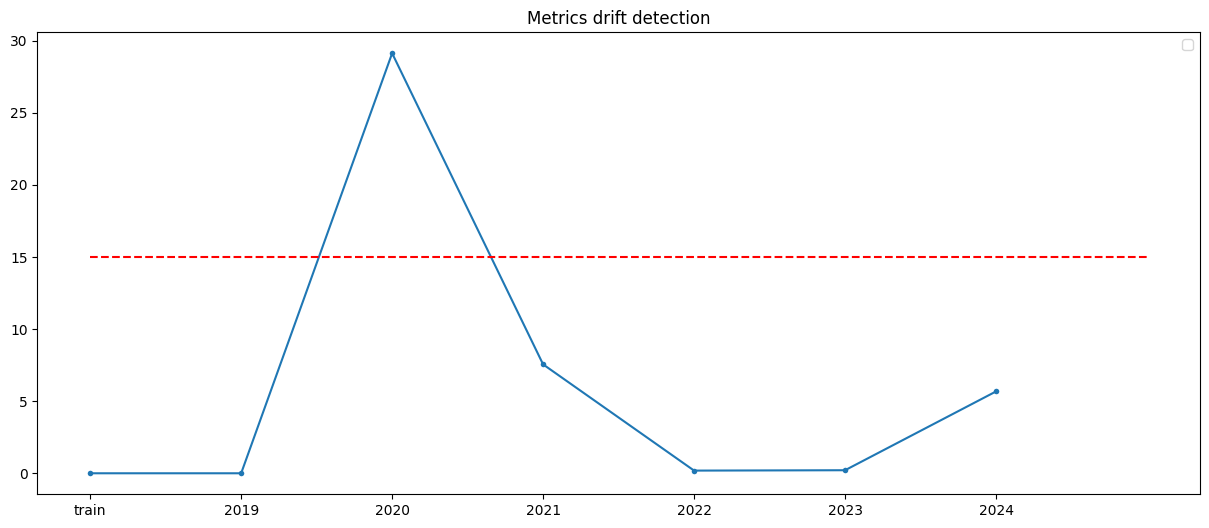

In [35]:
measures_threshold = 15
measures_drift, variances = calculate_measures_drift(measures, measures['train'], measures_threshold)

### Retrain on drift detection

ADAPTAR LA FUNCION PARA QUE FUNCIONE POR FEAT Y MES 

In [51]:
xais.to_csv('prueba.csv', sep=';', decimal='.', encoding='utf-8')

In [85]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import minkowski

def drift_on_explain_month(
        xais: pd.DataFrame
):
        """
                Calculate drift using Kolmogorov-Smirnov test on the SHAP values by feature and month
                Args:
                        - xais (pandas.DataFrame): Dataframe containing the month of the SHAP value, the feature asociated and the values for the training set and the prediction set.
                Returns:
                        - result (pandas.DataFrame): DataFrame containing the feature and the result of the test, divided by months.
        """
        feats = xais['Feature'].unique()
        rows = []
        
        for feats in xais['Feature'].unique():
                xais_feat = xais[xais['Feature'] == feats]
                ks_feat_pval, ks_feat_stat = ks_2samp(xais_feat['Previous'], xais_feat['Test'])
                for month in xais_feat.index:
                        xais_month = xais_feat.loc[month]
                        minkowski_distance = minkowski([xais_month['Previous']], [xais_month['Test']])
                        rows.append([feats, month, ks_feat_pval, ks_feat_stat, minkowski_distance])
        return pd.DataFrame(rows, columns=['Feature', 'Month', 'P-value', 'Statistic', 'Distance'])



Con todo:

In [58]:
max_pvalue = 0.05
max_distance = 10
max_diff_dist = 1
max_diff_pval = -0.35
model = XGBRegressor(**params)
model.fit(X_train, y_train)

# explainer = shap.KernelExplainer(model.predict, X_train)
explainer = shap.Explainer(model, masker=shap.maskers.Independent(data=X_train))
train_shap = explainer.shap_values(X_train.head(24))

retrain = []
distance = {}
pvalues={}
preds = {}
xais = {}
measures = {
    'train': {
        'R2': r2_score(y_train, model.predict(X_train)),
        'MAE': mean_absolute_error(y_train, model.predict(X_train)),
        'RMSE': root_mean_squared_error(y_train, model.predict(X_train))
    }
}

years = timeseries_rest.index.year.unique()
year_prev = years[0]

for year in timeseries_rest.index.year.unique():
    print(year)
    test_year = timeseries_rest[timeseries_rest.index.year == year]

    X_test = test_year.drop(columns=[new_target_column])
    y_test = test_year[new_target_column]

    preds[year], measures[str(year)], xais[year] = time_series_predict(
        model=model,
        prev_shap_values=train_shap,
        data=X_test,
        target=y_test,
        explainer=explainer,
        distance_metric='manhattan'
    )
    
    print(xais)
    xais_df = pd.DataFrame(xais[year]).reset_index().rename(columns={'index': 'Feature'})
    xais_df_prev = pd.DataFrame(xais[year_prev]).reset_index().rename(columns={'index': 'Feature'})
    drift = drift_on_explain(xais_df_prev['Test explained importance'], xais_df['Test explained importance'], max_pvalue, max_distance)
    pvalues[year] = drift['pvalue']
    distance[year] = drift['distance']

    diff_pval = pvalues[year] - pvalues[year_prev]
    diff_dist = distance[year] - distance[year_prev]

    print(diff_dist, diff_pval)

    if (diff_dist > max_diff_dist and diff_pval < max_diff_pval) or drift['pvalue'] < max_pvalue or drift['distance'] > max_distance:
        print(f"Drift detected at year {year}")
        retrain.append(year)
        year_prev = year
        model = XGBRegressor(**params)
        X_new_train = pd.concat([X_train, timeseries_rest[timeseries_rest.index.year <= year]])
        y_new_train = pd.concat([y_train, timeseries_rest[timeseries_rest.index.year <= year][new_target_column]])
        X_new_train = X_new_train[X_train.columns]

        model.fit(X_new_train, y_new_train)
        # explainer = shap.KernelExplainer(model.predict, X_new_train.head(24))
        explainer = shap.Explainer(model, masker=shap.maskers.Independent(data=X_new_train))
        train_shap = explainer.shap_values(X_new_train.head(24))
        print("Model retrained")
    else:
        print(f"No drift detected at year {year}")
    print("-----")


fig, axs = plt.subplots(4, 1, figsize=(15, 10))
sns.set_theme(style='darkgrid')
measures_df = pd.DataFrame(measures).T
sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=axs[0] , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[0]]):
    axs[0].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
axs[0].set_title(measures_df.columns[0])

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=axs[1] , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[1]]):
    axs[1].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
axs[1].set_title(measures_df.columns[1])

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=axs[2] , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[2]]):
    axs[2].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
axs[2].set_title(measures_df.columns[2])

for ax in axs[0:3]:
    for year in retrain:
        ax.axvline(x=str(year), color='gray', linestyle='dashed')

ax3_2 = axs[3].twinx()
ax3_2.grid(False)
sns.lineplot(x=pvalues.keys(), y=pvalues.values(), marker='o', markeredgewidth=0, markersize=6, ax=axs[3], linewidth=2, color='red', label='p-value')
for i, txt in enumerate(pvalues.values()):
    axs[3].annotate(f'{txt:.2f}', (list(pvalues.keys())[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray') 

sns.lineplot(x=distance.keys(), y=distance.values(), marker='o', markeredgewidth=0, markersize=6, ax=ax3_2, linewidth=2, color='purple', label='Distance')
for i, txt in enumerate(distance.values()):
    ax3_2.annotate(f'{txt:.2f}', (list(distance.keys())[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')

fig.tight_layout(pad=0.5)
fig.show()


2019
{'R2': 0.3082535610987128, 'MAE': 29175.104166666668, 'RMSE': 34003.3038858379}
{'Alemania_t-12': {1: {'prev': 0.1538067560709459, 'test': 0.31153883696540047}, 2: {'prev': 0.28435147142563455, 'test': 0.39641644709571044}, 3: {'prev': 0.5987944474251196, 'test': 0.855238873505542}, 4: {'prev': 0.8465991211299843, 'test': 0.8552778774701897}, 5: {'prev': 0.8970200037489825, 'test': 0.9555126046682831}, 6: {'prev': 0.9180039307382513, 'test': 0.9449253482193919}, 7: {'prev': 0.909442419950385, 'test': 0.7574296324246881}, 8: {'prev': 0.8967009395971799, 'test': 0.4031646266578018}, 9: {'prev': 1.0, 'test': 0.9923533064714438}, 10: {'prev': 0.9887242091084614, 'test': 1.0}, 11: {'prev': 0.1408781141837887, 'test': 0.2651512225227833}, 12: {'prev': 0.0, 'test': 0.0}}, 'Alemania_t-11': {1: {'prev': 0.7870625841197156, 'test': 0.6442118769066211}, 2: {'prev': 0.823995556647015, 'test': 0.15343054570170295}, 3: {'prev': 1.0, 'test': 0.17144849083082897}, 4: {'prev': 0.5004744236225587, 

/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_pre

{'Alemania_t-12': {1: {'prev': 0.1538067560709459, 'test': 1.0}, 2: {'prev': 0.28435147142563455, 'test': 0.9562178709058418}, 3: {'prev': 0.5987944474251196, 'test': 0.04293682982553358}, 4: {'prev': 0.8465991211299843, 'test': 0.04070754487448021}, 5: {'prev': 0.8970200037489825, 'test': 0.061775586552662805}, 6: {'prev': 0.9180039307382513, 'test': 0.09515060127076537}, 7: {'prev': 0.909442419950385, 'test': 0.03156081946514729}, 8: {'prev': 0.8967009395971799, 'test': 0.032415422666739364}, 9: {'prev': 1.0, 'test': 0.0}, 10: {'prev': 0.9887242091084614, 'test': 0.05035392896355093}, 11: {'prev': 0.1408781141837887, 'test': 0.05145142388050159}, 12: {'prev': 0.0, 'test': 0.07844180669652936}}, 'Alemania_t-11': {1: {'prev': 0.7870625841197156, 'test': 0.41318659146841047}, 2: {'prev': 0.823995556647015, 'test': 0.24316069525635983}, 3: {'prev': 1.0, 'test': 0.00023482700192511234}, 4: {'prev': 0.5004744236225587, 'test': 0.0030890498494357834}, 5: {'prev': 0.42243799183334363, 'test'

/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_prev - min_prev)
/tmp/ipykernel_1988508/621715371.py:52: RuntimeWarning: invalid value encountered in scalar divide
  test_val_norm = (val[i] - min_test) / (max_test - min_test)
/tmp/ipykernel_1988508/621715371.py:51: RuntimeWarning: invalid value encountered in scalar divide
  prev_val_norm = (prev_shap_values[j][i] - min_prev) / (max_pre

Con feature importance:

2019
{'R2': -1.062590599632705, 'MAE': 47596.499348958336, 'RMSE': 58715.68984726674}
2020
{'R2': -27.91725620977416, 'MAE': 147546.884765625, 'RMSE': 153614.1050384154}
2021
{'R2': -5.618918442639532, 'MAE': 91172.55924479167, 'RMSE': 100192.89075160737}
2022
{'R2': -1.1844333215409644, 'MAE': 44285.115234375, 'RMSE': 51943.5328281435}
2023
{'R2': -0.6267772365912867, 'MAE': 48922.127604166664, 'RMSE': 56107.12850168624}
2024
{'R2': 0.0, 'MAE': 173147.2109375, 'RMSE': 177161.41082326212}


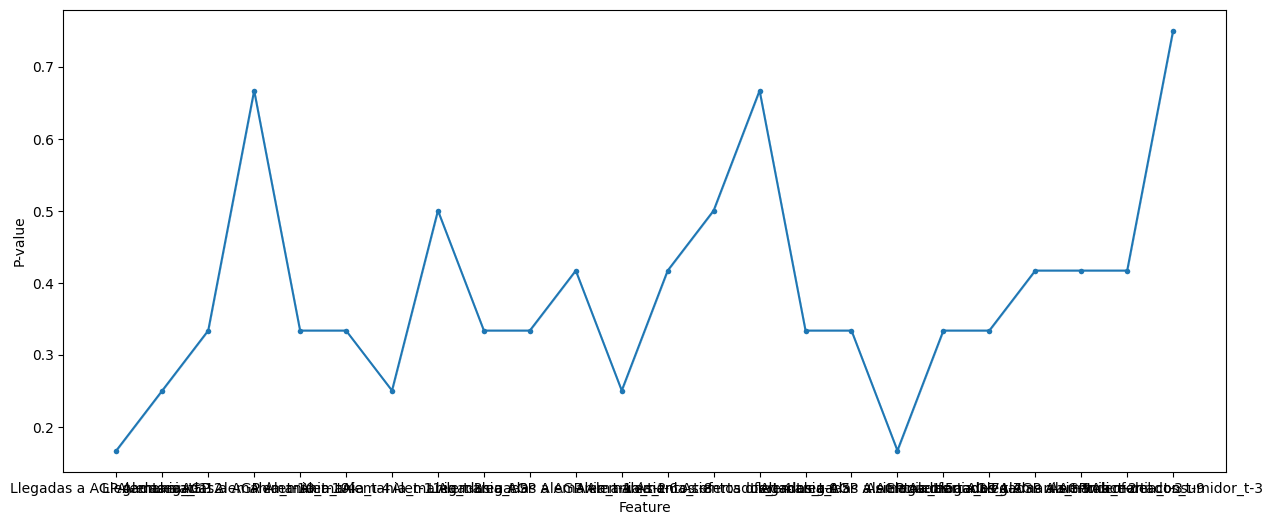

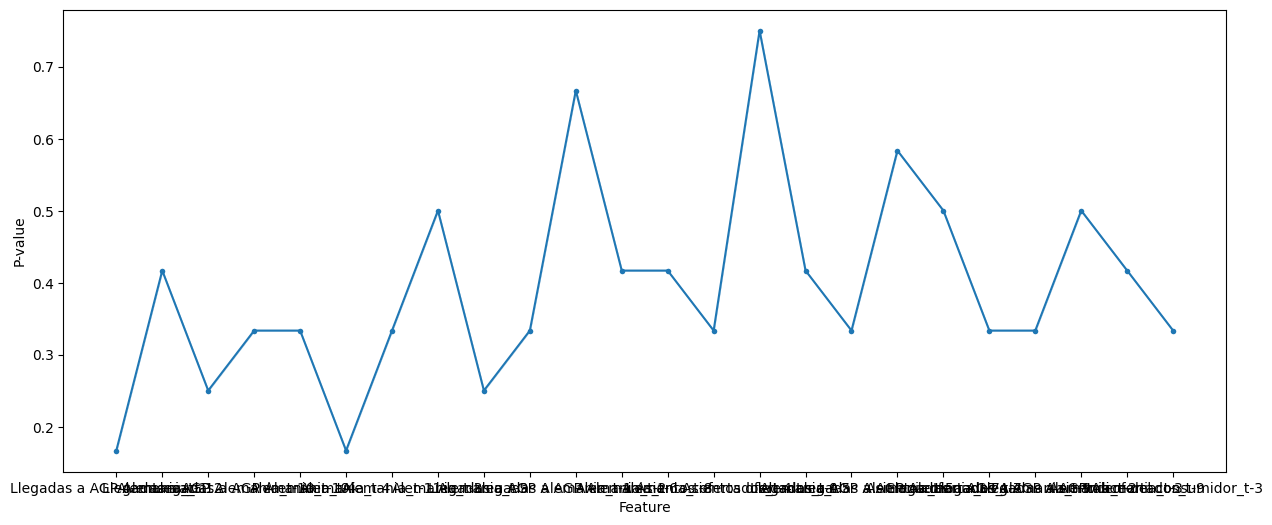

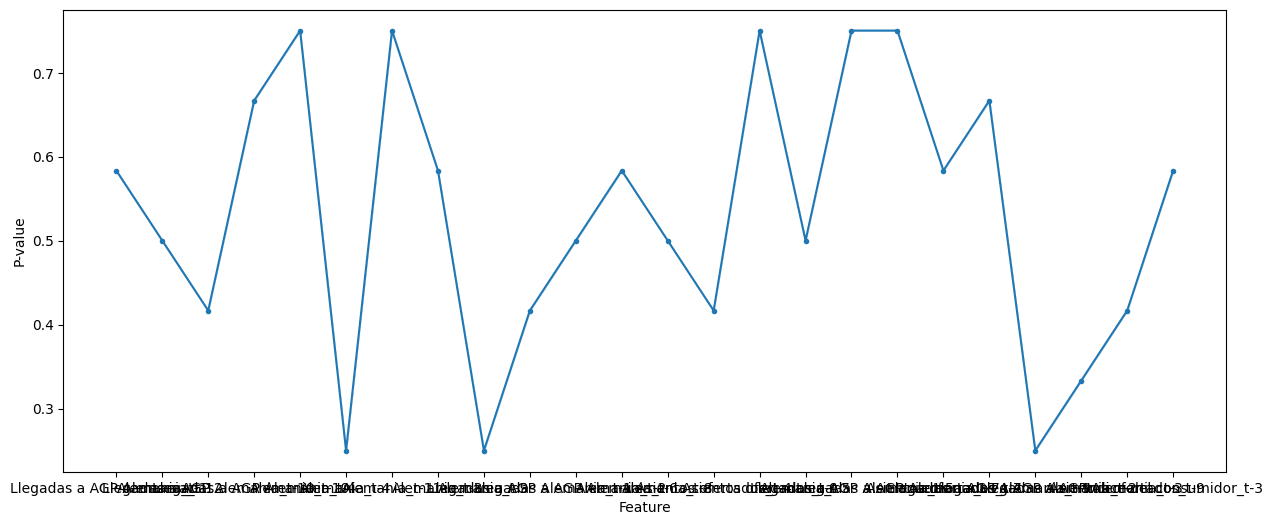

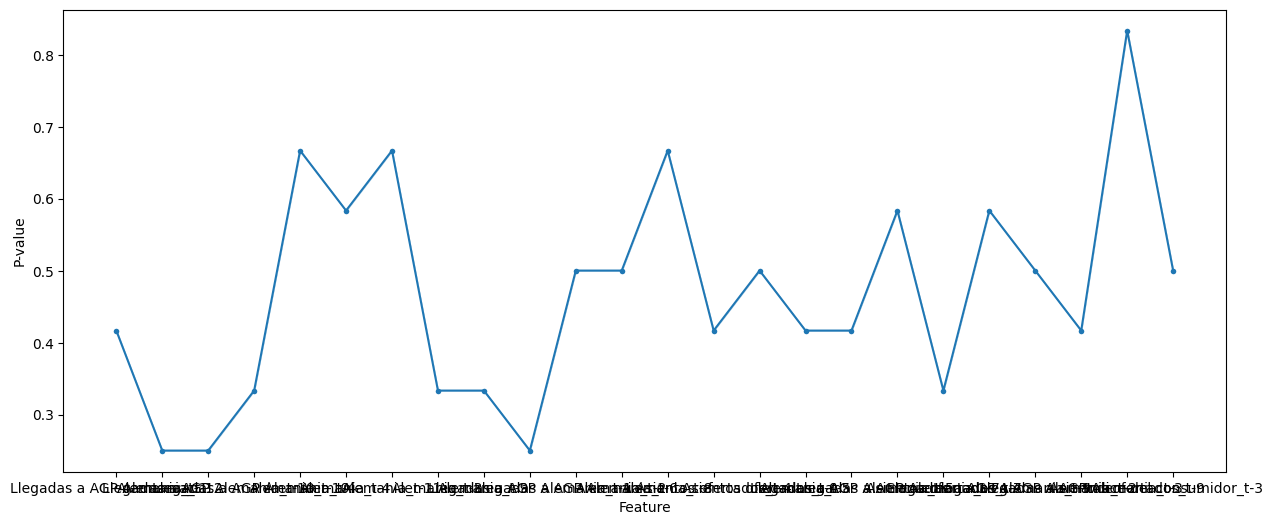

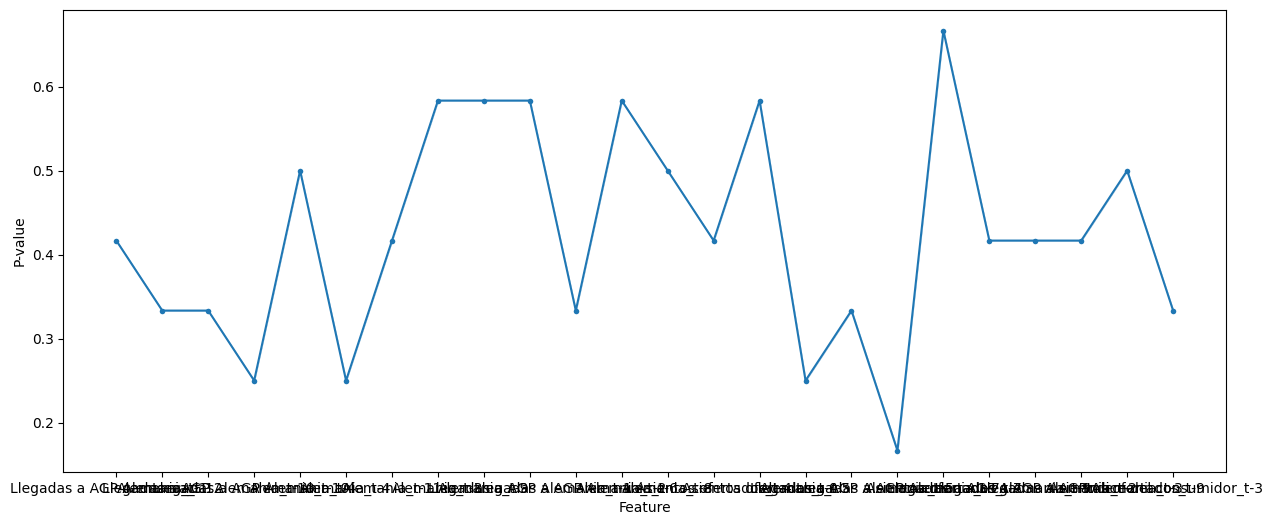

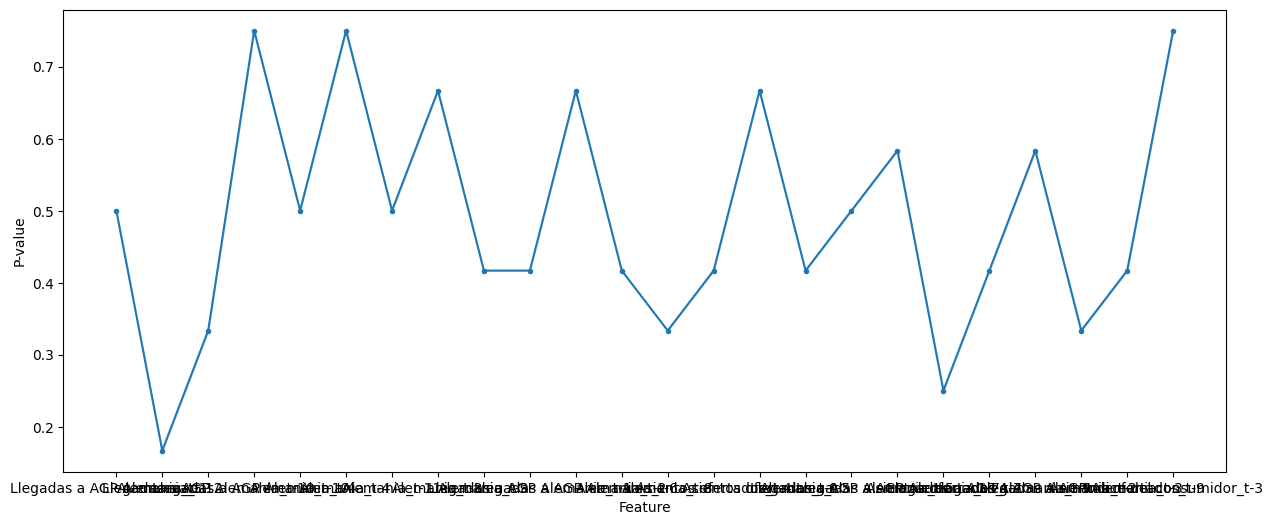

In [94]:
max_pvalue = 0.05
max_distance = 10
max_diff_dist = 1
max_diff_pval = -0.35
# model = MLPRegressor(**params)
model = XGBRegressor(**params)
model.fit(X_train_ft, y_train)

cols = X_train_ft.columns.to_list()
cols.append(new_target_column)
rest_ft = timeseries_rest.copy()[cols]

# explainer = shap.KernelExplainer(model.predict, X_train_ft)
explainer = shap.Explainer(model, masker=shap.maskers.Independent(data=X_train_ft))
train_shap = explainer.shap_values(X_train_ft.head(24))

retrain = []
pvalues = {}
distance ={}
preds = {}
xais = {}
measures = {
    'train': {
        'R2': r2_score(y_train, model.predict(X_train_ft)),
        'MAE': mean_absolute_error(y_train, model.predict(X_train_ft)),
        'RMSE': root_mean_squared_error(y_train, model.predict(X_train_ft))
    }
}

years = rest_ft.index.year.unique()
year_prev = years[0]

for year in years:
    print(year)
    test_year = rest_ft[rest_ft.index.year == year]

    X_test = test_year.drop(columns=[new_target_column])
    y_test = test_year[new_target_column]

    preds[year], measures[str(year)], xais[year] = time_series_predict(
        model=model,
        prev_shap_values=train_shap,
        data=X_test,
        target=y_test,
        explainer=explainer
    )
    # xais dataframe creation
    feats = []
    rows = []
    for yyyy, xai_feat in xais.items():
        if yyyy == year:
            for feat, month in xai_feat.items():
                for mm, val in month.items():
                    feats.append(pd.to_datetime(f"{yyyy}-{mm}", format='%Y-%m'))
                    rows.append(
                        [feat,
                        val['prev'],
                        val['test']]
                    )
        else:
            continue

    xai_df = pd.DataFrame(rows, index=feats, columns=['Feature', 'Previous', 'Test'])

    res = drift_on_explain_month(xai_df)
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.lineplot(x='Feature', y='P-value', data=res, marker='o', markeredgewidth=0, markersize=4, ax=ax)

    fig.show()
    # drift = drift_on_explain(xais_df_prev['Test explained importance'], xais_df['Test explained importance'])
    # pvalues[year] = float(drift['pvalue'])
    # distance[year] = float(drift['distance'])

    # diff_pval = pvalues[year] - pvalues[year_prev]
    # diff_dist = distance[year] - distance[year_prev]
    
    # print(
    #     f"P-value: {pvalues[year]:.2f} | Distance: {distance[year]:.2f}\nDiff P-value: {diff_pval:.2f} | Diff Distance: {diff_dist:.2f}"
    # )
    # if (diff_dist > max_diff_dist and diff_pval < max_diff_pval) or drift['pvalue'] < max_pvalue or drift['distance'] > max_distance:
    #     print(f"Drift detected at year {year}")
    #     retrain.append(year)
    #     year_prev = year
    #     model = XGBRegressor(**params)

    #     X_new_train = pd.concat([X_train, rest_ft[rest_ft.index.year <= year]])
    #     y_new_train = pd.concat([y_train, rest_ft[rest_ft.index.year <= year][new_target_column]])
    #     X_new_train = X_new_train[X_train_ft.columns]
        
    #     model.fit(X_new_train, y_new_train)
    #     # explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_new_train, 24))
    #     explainer = shap.Explainer(model, masker=shap.maskers.Independent(data=X_new_train))
    #     train_shap = explainer.shap_values(X_new_train.head(24))
    #     print("Model retrained")
    # else:
    #     print(f"No drift detected at year {year}")
    # print("-----")


# fig, axs = plt.subplots(4, 1, figsize=(15, 10))
# sns.set_theme(style='darkgrid')
# measures_df = pd.DataFrame(measures).T
# sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=axs[0] , linewidth=2)
# for i, txt in enumerate(measures_df[measures_df.columns[0]]):
#     axs[0].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
# axs[0].set_title(measures_df.columns[0])

# sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=axs[1] , linewidth=2)
# for i, txt in enumerate(measures_df[measures_df.columns[1]]):
#     axs[1].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
# axs[1].set_title(measures_df.columns[1])

# sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=axs[2] , linewidth=2)
# for i, txt in enumerate(measures_df[measures_df.columns[2]]):
#     axs[2].annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
# axs[2].set_title(measures_df.columns[2])

# for ax in axs[0:3]:
#     for year in retrain:
#         ax.axvline(x=str(year), color='r', linestyle='dashed')

# ax3_2 = axs[3].twinx()
# ax3_2.grid(False)
# sns.lineplot(x=pvalues.keys(), y=pvalues.values(), marker='o', markeredgewidth=0, markersize=6, ax=axs[3], linewidth=2, color='red', label='p-value')
# for i, txt in enumerate(pvalues.values()):
#     axs[3].annotate(f'{txt:.2f}', (list(pvalues.keys())[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray') 

# sns.lineplot(x=distance.keys(), y=distance.values(), marker='o', markeredgewidth=0, markersize=6, ax=ax3_2, linewidth=2, color='purple', label='Distance')
# for i, txt in enumerate(distance.values()):
#     ax3_2.annotate(f'{txt:.2f}', (list(distance.keys())[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')

# axs[3].set_title('Drift detection')
# axs[3].legend(loc='upper right')
# ax3_2.legend(loc='lower right')

# fig.tight_layout(pad=0.5)
# fig.show()



## Anlysis by month

## Analysis by trimester